# Entropy-Complexity Planes for FMA Rock Subgenres

This notebook computes permutation entropy (PE) and statistical complexity (CE) for FMA rock tracks using four different signal representations:
1. **Amplitude** — Hilbert envelope
2. **Flux** — Spectral flux
3. **Harmony** — CQT chroma → circle-of-fifths angle
4. **Spectral Entropy** — frame-wise spectral entropy

Each entropy-complexity plane shows tracks colored by their Rock subgenre.

In [11]:
import sys, os, ast, warnings, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import ordpy
from tqdm import tqdm

warnings.filterwarnings('ignore')

# Add project root to path so we can import chaos_methods
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.chaos_methods import (
    ordpy_amplitude, ordpy_flux, ordpy_harmony, ordpy_specentropy
)

# Paths
TRACKS_CSV  = os.path.join(PROJECT_ROOT, 'data', 'fma_metadata', 'tracks.csv')
GENRES_CSV  = os.path.join(PROJECT_ROOT, 'data', 'fma_metadata', 'genres.csv')
FMA_SMALL   = os.path.join(PROJECT_ROOT, 'data', 'fma_small')

print(f'Project root: {PROJECT_ROOT}')
print(f'FMA small dir exists: {os.path.isdir(FMA_SMALL)}')

Project root: /Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork
FMA small dir exists: True


## 1. Load Metadata

In [12]:
# ── Load genres ───────────────────────────────────────────────────────
genres_df = pd.read_csv(GENRES_CSV, index_col=0)
print(f'Total genres: {len(genres_df)}')

# ── Load tracks (complex multi-row header) ────────────────────────────
# The tracks.csv has 3 header rows (row 0: group, row 1: column name, row 2: blank)
# We use rows 0 and 1 as a MultiIndex header, then skip row 2
tracks_raw = pd.read_csv(TRACKS_CSV, header=[0, 1], low_memory=False)

# The first column is track_id but appears as unnamed
# Flatten multi-index columns and set track_id as index
# Drop the first row which contains 'track_id' label
tracks_raw = tracks_raw.iloc[1:]  # skip the row with 'track_id'

# Get flat column names from level 1
flat_cols = [col[1] if col[1] != '' else col[0] for col in tracks_raw.columns]
tracks_raw.columns = flat_cols

# The first column should be track_id (unnamed)
first_col = tracks_raw.columns[0]
tracks_raw = tracks_raw.rename(columns={first_col: 'track_id'})
tracks_raw['track_id'] = pd.to_numeric(tracks_raw['track_id'], errors='coerce')
tracks_raw = tracks_raw.dropna(subset=['track_id'])
tracks_raw['track_id'] = tracks_raw['track_id'].astype(int)
tracks_raw = tracks_raw.set_index('track_id')

print(f'Total tracks: {len(tracks_raw)}')
print(f'Columns sample: {list(tracks_raw.columns[:10])}')

Total genres: 163
Total tracks: 106574
Columns sample: ['comments', 'date_created', 'date_released', 'engineer', 'favorites', 'id', 'information', 'listens', 'producer', 'tags']


## 2. Identify Rock Subgenres and Filter Tracks

In [13]:
ROCK_TOP_LEVEL_ID = 12

# Find all genres that belong to Rock (top_level == 12)
rock_genres = genres_df[genres_df['top_level'] == ROCK_TOP_LEVEL_ID].copy()
rock_genre_ids = set(rock_genres.index.tolist())
rock_genre_names = rock_genres['title'].to_dict()  # {genre_id: genre_title}

print(f'Rock subgenres found: {len(rock_genre_ids)}')
for gid, name in sorted(rock_genre_names.items(), key=lambda x: x[1]):
    print(f'  {gid:>4d}: {name}')

Rock subgenres found: 29
   167: Black-Metal
   101: Death-Metal
    64: Electro-Punk
    85: Garage
   314: Goth
   439: Grindcore
   109: Hardcore
    66: Indie-Rock
    70: Industrial
    36: Krautrock
    27: Lo-Fi
    45: Loud-Rock
    31: Metal
    88: New Wave
    71: No Wave
    53: Noise-Rock
    89: Post-Punk
    26: Post-Rock
   111: Power-Pop
    98: Progressive
    58: Psych-Rock
    25: Punk
    12: Rock
   440: Rock Opera
   359: Shoegaze
    90: Sludge
   113: Space-Rock
   404: Surf
   361: Thrash


In [14]:
def parse_genre_list(val):
    """Parse the genres_all column which contains Python-style lists like '[21, 12]'."""
    if pd.isna(val) or val == '':
        return []
    try:
        return ast.literal_eval(str(val))
    except:
        return []

def get_track_audio_path(track_id):
    """Construct the audio file path for a given FMA track ID."""
    tid_str = f'{track_id:06d}'
    folder = tid_str[:3]
    return os.path.join(FMA_SMALL, folder, f'{tid_str}.mp3')

def get_most_specific_rock_subgenre(genre_ids, rock_genre_ids, rock_genre_names):
    """
    From a list of genre IDs for a track, find the most specific Rock subgenre.
    Prefer non-'Rock' subgenres over the generic 'Rock' (id=12).
    """
    rock_matches = [gid for gid in genre_ids if gid in rock_genre_ids]
    if not rock_matches:
        return None, None
    # Prefer specific subgenres over generic Rock
    specific = [gid for gid in rock_matches if gid != ROCK_TOP_LEVEL_ID]
    if specific:
        chosen = specific[0]
    else:
        chosen = ROCK_TOP_LEVEL_ID
    return chosen, rock_genre_names.get(chosen, 'Unknown')

# ── Handle duplicate column names ─────────────────────────────────────
# tracks.csv may have duplicate column names after flattening.
# We need 'genres_all' from the 'track' group.
# Find the right 'genres_all' column
genres_all_cols = [c for c in tracks_raw.columns if 'genres_all' in str(c)]
print(f'Columns containing genres_all: {genres_all_cols}')

# Use the first one
genres_all_col = genres_all_cols[0] if genres_all_cols else 'genres_all'

# ── Filter tracks that are in fma_small and belong to Rock ────────────
rock_tracks = []  # List of (track_id, subgenre_id, subgenre_name, file_path)

for track_id in tqdm(tracks_raw.index, desc='Filtering Rock tracks'):
    # Check if audio file exists
    fpath = get_track_audio_path(track_id)
    if not os.path.isfile(fpath):
        continue
    
    # Parse genres
    genre_ids = parse_genre_list(tracks_raw.loc[track_id, genres_all_col])
    
    # Check if track belongs to Rock
    sub_id, sub_name = get_most_specific_rock_subgenre(genre_ids, rock_genre_ids, rock_genre_names)
    if sub_id is not None:
        rock_tracks.append({
            'track_id': track_id,
            'subgenre_id': sub_id,
            'subgenre': sub_name,
            'file_path': fpath
        })

rock_df = pd.DataFrame(rock_tracks)
print(f'\nTotal Rock tracks in fma_small: {len(rock_df)}')
print(f'\nTracks per subgenre:')
print(rock_df['subgenre'].value_counts().to_string())

Columns containing genres_all: ['genres_all']


Filtering Rock tracks: 100%|██████████| 106574/106574 [00:00<00:00, 113431.97it/s]


Total Rock tracks in fma_small: 1000

Tracks per subgenre:
subgenre
Punk            203
Indie-Rock      138
Rock            107
Post-Rock        83
Surf             80
Post-Punk        56
Metal            49
Psych-Rock       43
New Wave         35
Death-Metal      30
Progressive      26
Industrial       22
Loud-Rock        22
Electro-Punk     20
Lo-Fi            14
Garage           14
Rock Opera       11
Space-Rock       11
Black-Metal      10
Hardcore          9
Goth              5
Thrash            4
Krautrock         3
No Wave           3
Shoegaze          1
Power-Pop         1


## 3. Compute Entropy-Complexity Values

We compute PE and CE for each rock track using all 4 methods. This may take some time.

In [15]:
METHODS = {
    'amplitude':    ordpy_amplitude,
    'flux':         ordpy_flux,
    'harmony':      ordpy_harmony,
    'specentropy':  ordpy_specentropy,
}

DIM = 6
HOP = 1

# Results dict: method_name -> DataFrame with columns [track_id, H, C, subgenre]
results = {}

for method_idx, (method_name, method_func) in enumerate(METHODS.items(), 1):
    print(f'\n{"="*60}')
    print(f'[{method_idx}/{len(METHODS)}] Computing: {method_name} (dim={DIM}, hop={HOP})')
    print(f'{"="*60}')
    
    rows = []
    errors = 0
    t0 = time.time()
    
    pbar = tqdm(total=len(rock_df), desc=f'{method_name}', 
                bar_format='{l_bar}{bar:30}{r_bar}',
                file=sys.stdout)
    
    for i, (_, row) in enumerate(rock_df.iterrows()):
        try:
            H, C = method_func(row['file_path'], dim_size=DIM, hop_size=HOP)
            rows.append({
                'track_id': row['track_id'],
                'H': H,
                'C': C,
                'subgenre': row['subgenre'],
                'subgenre_id': row['subgenre_id']
            })
        except Exception as e:
            errors += 1
        
        pbar.update(1)
        pbar.set_postfix(ok=len(rows), err=errors)
    
    pbar.close()
    elapsed = time.time() - t0
    
    df = pd.DataFrame(rows).dropna(subset=['H', 'C'])
    results[method_name] = df
    print(f'  ✓ {len(df)} tracks computed, {errors} errors, {elapsed:.1f}s elapsed')


[1/4] Computing: amplitude (dim=6, hop=1)
amplitude:  59%|█████████████████▋            | 590/1000 [01:34<00:49,  8.23it/s, err=1, ok=589]

[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


amplitude: 100%|██████████████████████████████| 1000/1000 [02:41<00:00,  6.20it/s, err=1, ok=999]
  ✓ 999 tracks computed, 1 errors, 161.2s elapsed

[2/4] Computing: flux (dim=6, hop=1)
flux:  59%|█████████████████▋            | 591/1000 [00:43<00:26, 15.26it/s, err=1, ok=590]

[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


flux: 100%|██████████████████████████████| 1000/1000 [01:14<00:00, 13.44it/s, err=1, ok=999]
  ✓ 999 tracks computed, 1 errors, 74.4s elapsed

[3/4] Computing: harmony (dim=6, hop=1)
harmony:  59%|█████████████████▋            | 591/1000 [00:48<00:29, 13.72it/s, err=1, ok=590]

[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


harmony: 100%|██████████████████████████████| 1000/1000 [01:21<00:00, 12.33it/s, err=1, ok=999]
  ✓ 999 tracks computed, 1 errors, 81.1s elapsed

[4/4] Computing: specentropy (dim=6, hop=1)
specentropy:  59%|█████████████████▋            | 589/1000 [05:07<03:31,  1.95it/s, err=1, ok=588]

[src/libmpg123/parse.c:do_readahead():1083] warning: Cannot read next header, a one-frame stream? Duh...


specentropy: 100%|██████████████████████████████| 1000/1000 [08:41<00:00,  1.92it/s, err=1, ok=999]
  ✓ 999 tracks computed, 1 errors, 521.7s elapsed


## 4. Plot Entropy-Complexity Planes

In [16]:
# Get ordpy boundary curves
max_HC = ordpy.maximum_complexity_entropy(DIM, 1)
min_HC = ordpy.minimum_complexity_entropy(DIM, 1)

# Build a consistent colormap across all methods
all_subgenres = sorted(rock_df['subgenre'].unique())
n_subgenres = len(all_subgenres)
cmap = cm.get_cmap('tab20', max(n_subgenres, 20))
# For more than 20 subgenres, extend with tab20b
if n_subgenres > 20:
    cmap2 = cm.get_cmap('tab20b', n_subgenres - 20)
    colors = [cmap(i) for i in range(20)] + [cmap2(i) for i in range(n_subgenres - 20)]
else:
    colors = [cmap(i) for i in range(n_subgenres)]

subgenre_colors = {sg: colors[i] for i, sg in enumerate(all_subgenres)}

print(f'Color mapping for {n_subgenres} subgenres:')
for sg, color in subgenre_colors.items():
    print(f'  {sg}')

Color mapping for 26 subgenres:
  Black-Metal
  Death-Metal
  Electro-Punk
  Garage
  Goth
  Hardcore
  Indie-Rock
  Industrial
  Krautrock
  Lo-Fi
  Loud-Rock
  Metal
  New Wave
  No Wave
  Post-Punk
  Post-Rock
  Power-Pop
  Progressive
  Psych-Rock
  Punk
  Rock
  Rock Opera
  Shoegaze
  Space-Rock
  Surf
  Thrash


Saved combined plot → /Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/plots/fma_rock_subgenres/entropy_complexity_rock_subgenres_d6_h1.png


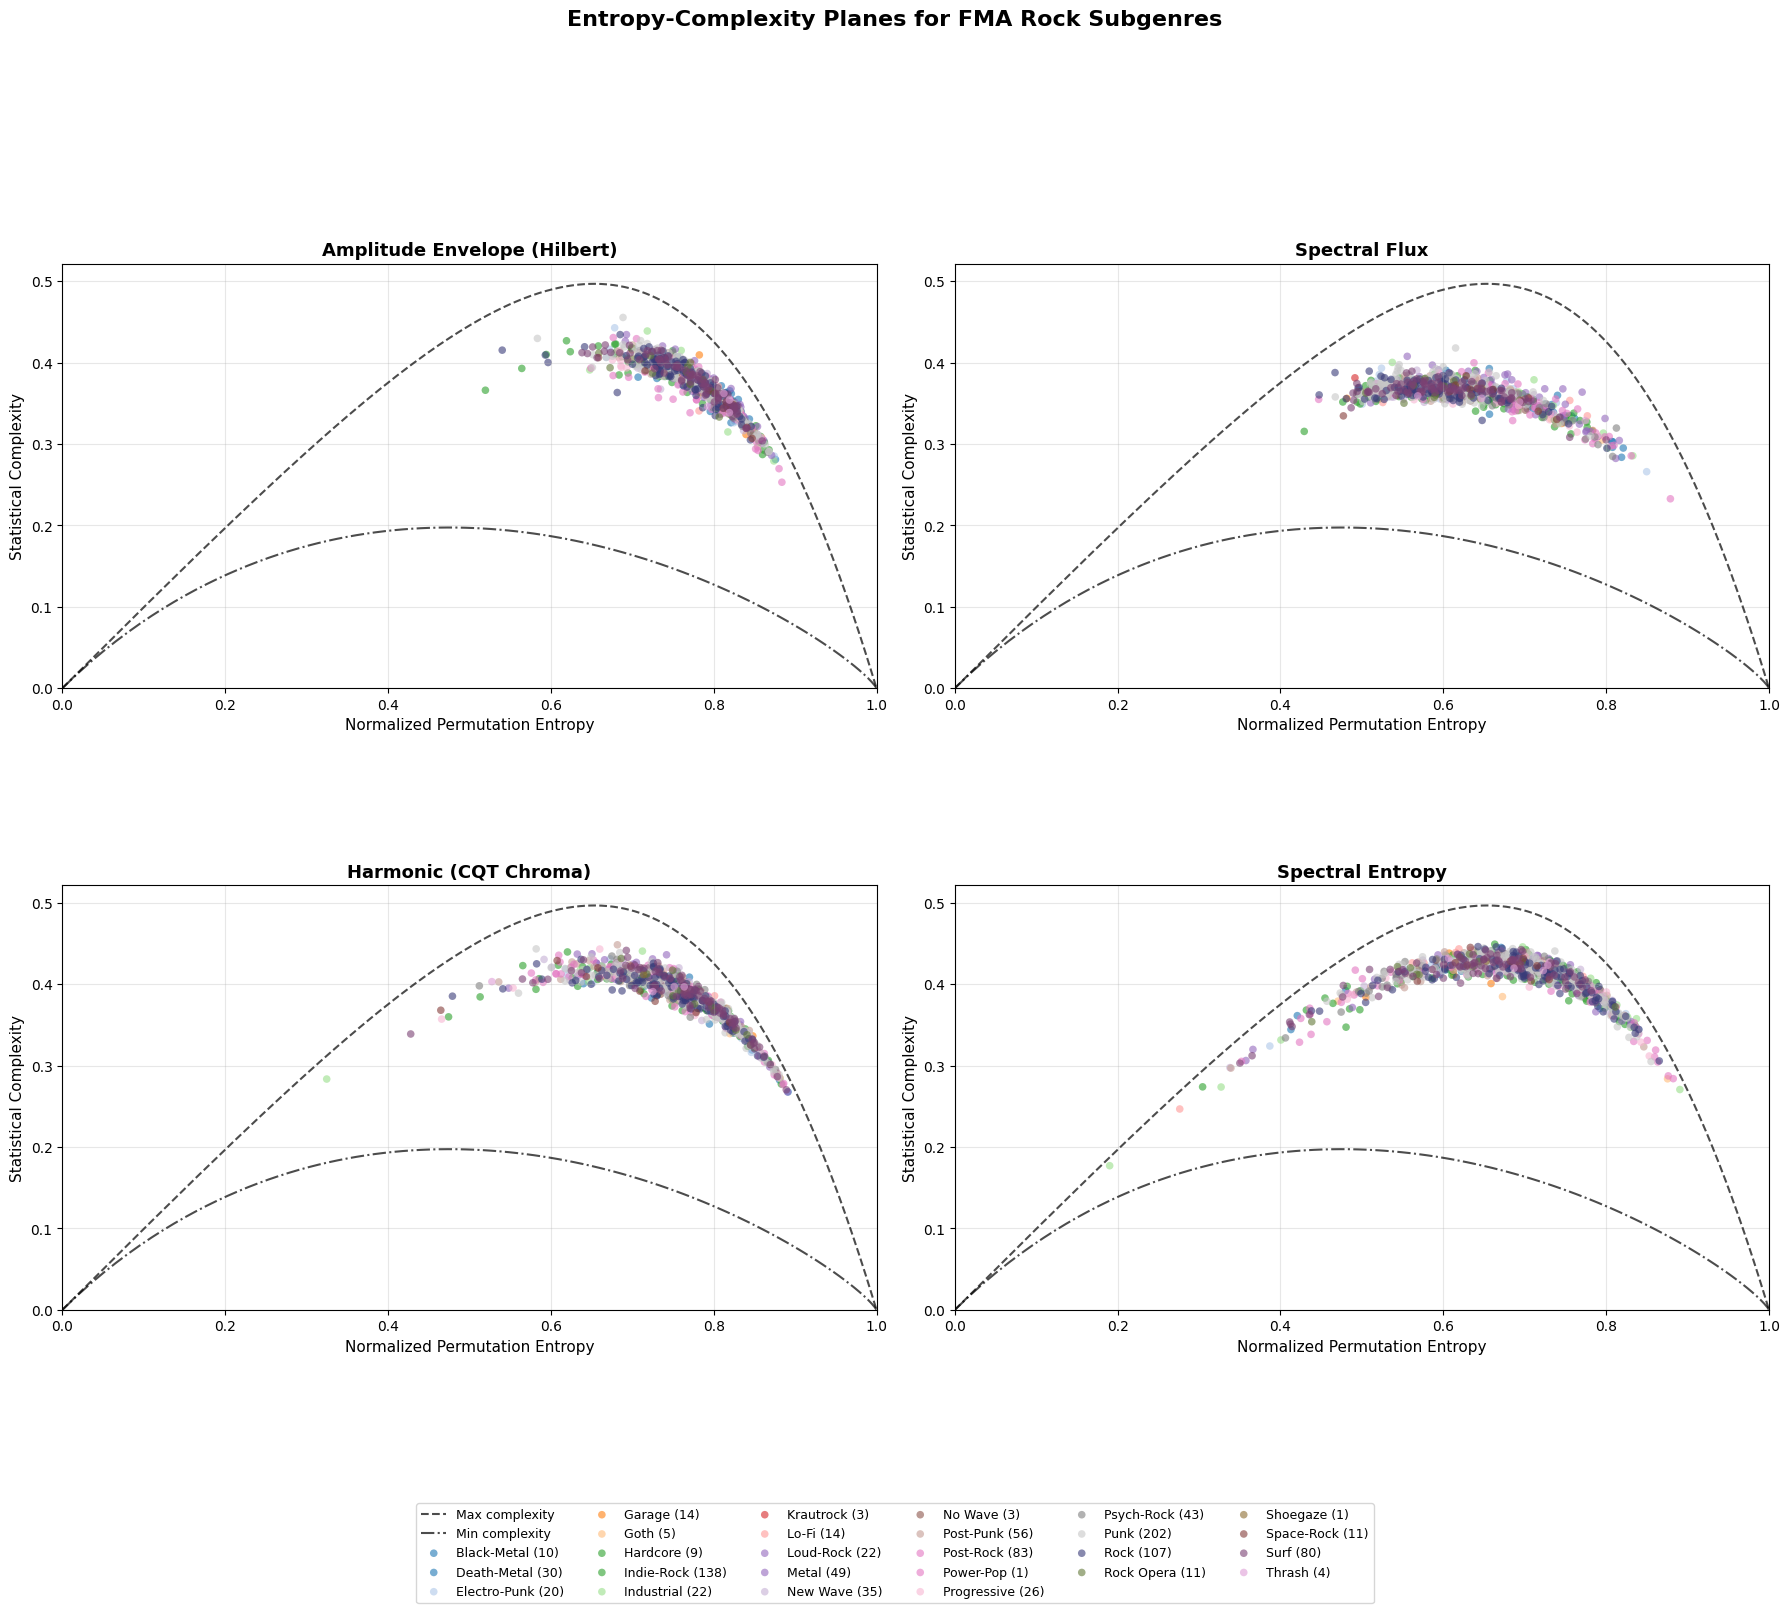

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('Entropy-Complexity Planes for FMA Rock Subgenres', fontsize=16, fontweight='bold')

method_titles = {
    'amplitude':   'Amplitude Envelope (Hilbert)',
    'flux':        'Spectral Flux',
    'harmony':     'Harmonic (CQT Chroma)',
    'specentropy': 'Spectral Entropy',
}

for idx, (method_name, ax) in enumerate(zip(METHODS.keys(), axes.flat)):
    df = results[method_name]
    
    # Plot boundary curves
    ax.plot(max_HC[:, 0], max_HC[:, 1], 'k--', linewidth=1.5, alpha=0.7, label='Max complexity')
    ax.plot(min_HC[:, 0], min_HC[:, 1], 'k-.', linewidth=1.5, alpha=0.7, label='Min complexity')
    
    # Plot each subgenre with its own color
    for sg in all_subgenres:
        mask = df['subgenre'] == sg
        if mask.sum() == 0:
            continue
        ax.scatter(
            df.loc[mask, 'H'], df.loc[mask, 'C'],
            c=[subgenre_colors[sg]],
            label=f'{sg} ({mask.sum()})',
            s=30, alpha=0.6, edgecolors='none'
        )
    
    ax.set_xlabel('Normalized Permutation Entropy', fontsize=11)
    ax.set_ylabel('Statistical Complexity', fontsize=11)
    ax.set_title(method_titles.get(method_name, method_name), fontsize=13, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, None)  # let y auto-scale to data
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', 'box')

# Add a single shared legend at the bottom
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=min(6, len(handles)),
           fontsize=9, bbox_to_anchor=(0.5, -0.02), frameon=True)

plt.tight_layout(rect=[0, 0.05, 1, 0.96])

# Save
out_dir = os.path.join(PROJECT_ROOT, 'plots', 'fma_rock_subgenres')
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, f'entropy_complexity_rock_subgenres_d{DIM}_h{HOP}.png')
plt.savefig(out_path, dpi=150, bbox_inches='tight')
print(f'Saved combined plot → {out_path}')
plt.show()

## 5. Individual Plots per Method (larger, more readable)

Saved → /Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/plots/fma_rock_subgenres/EC_amplitude_rock_d6_h1.png


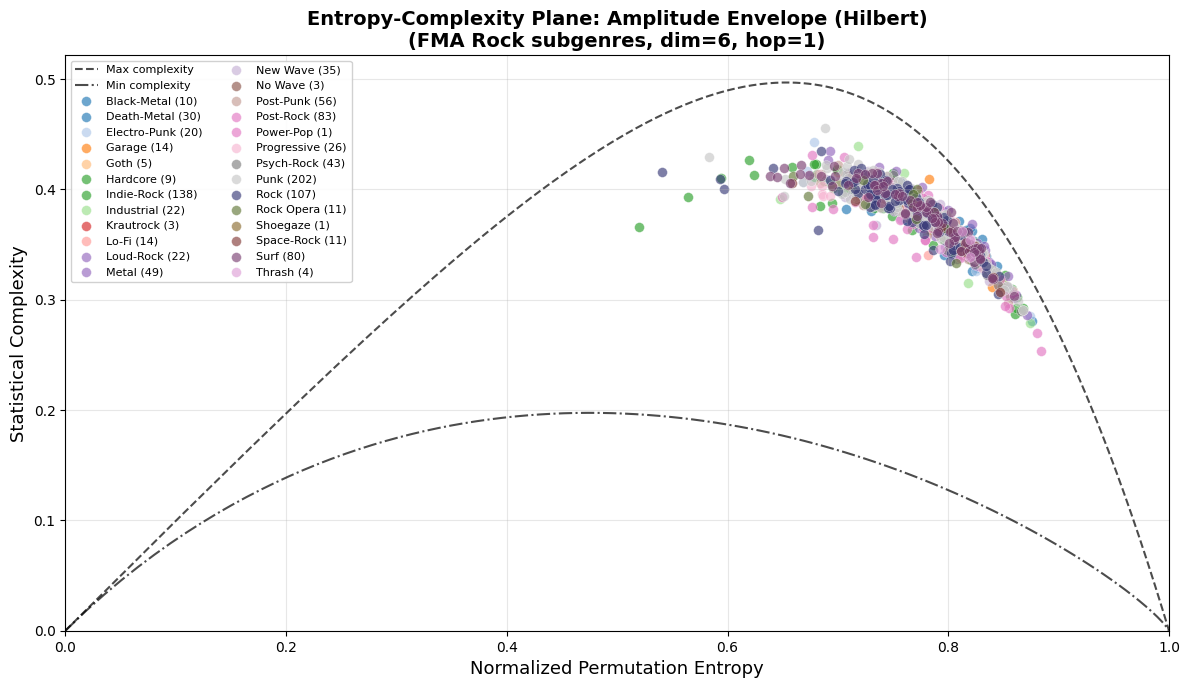

Saved → /Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/plots/fma_rock_subgenres/EC_flux_rock_d6_h1.png


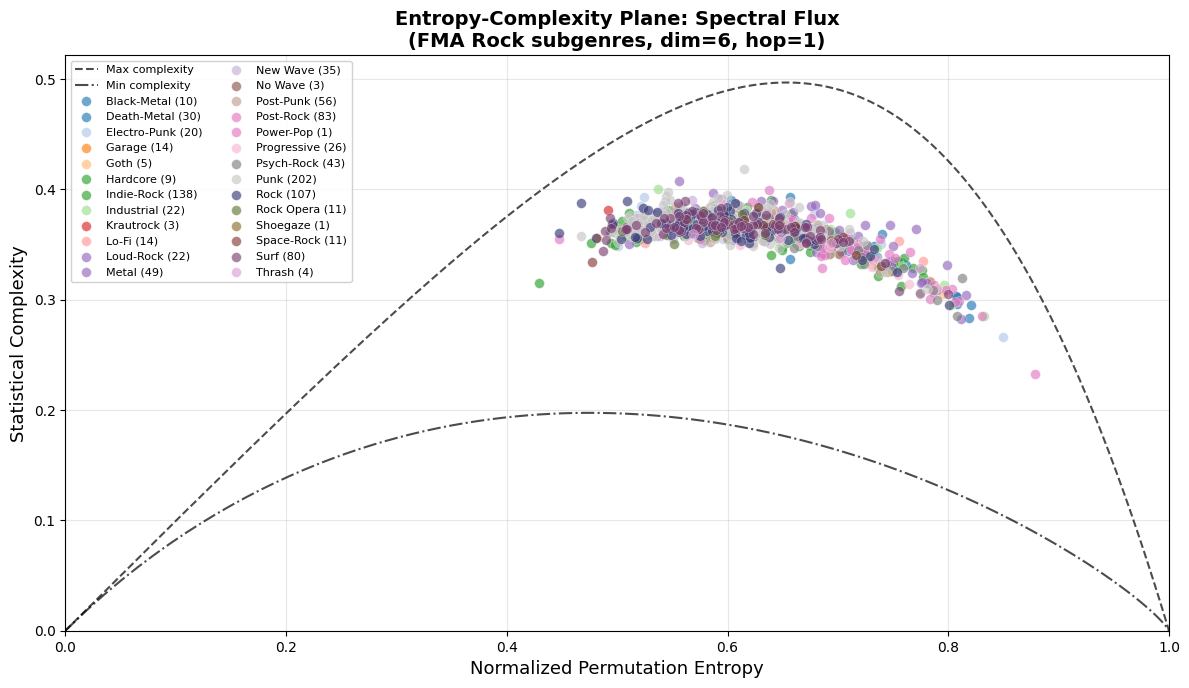

Saved → /Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/plots/fma_rock_subgenres/EC_harmony_rock_d6_h1.png


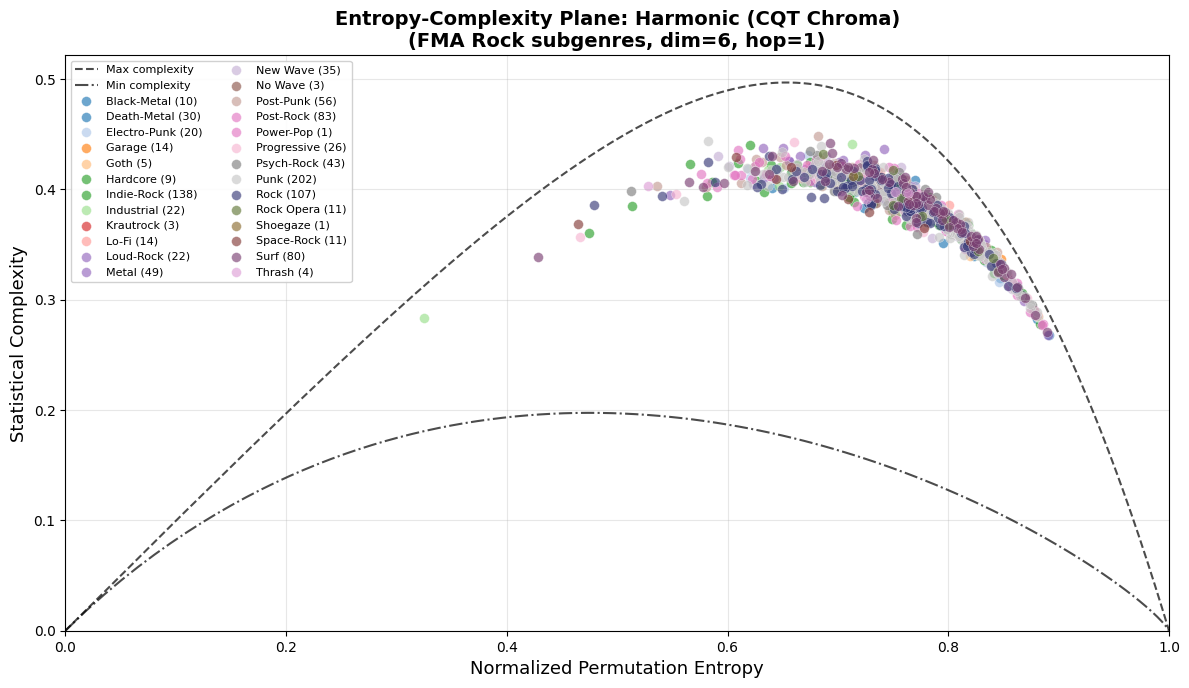

Saved → /Users/mverzhbitskiy/Documents/GitHub/3rdCourseWork/plots/fma_rock_subgenres/EC_specentropy_rock_d6_h1.png


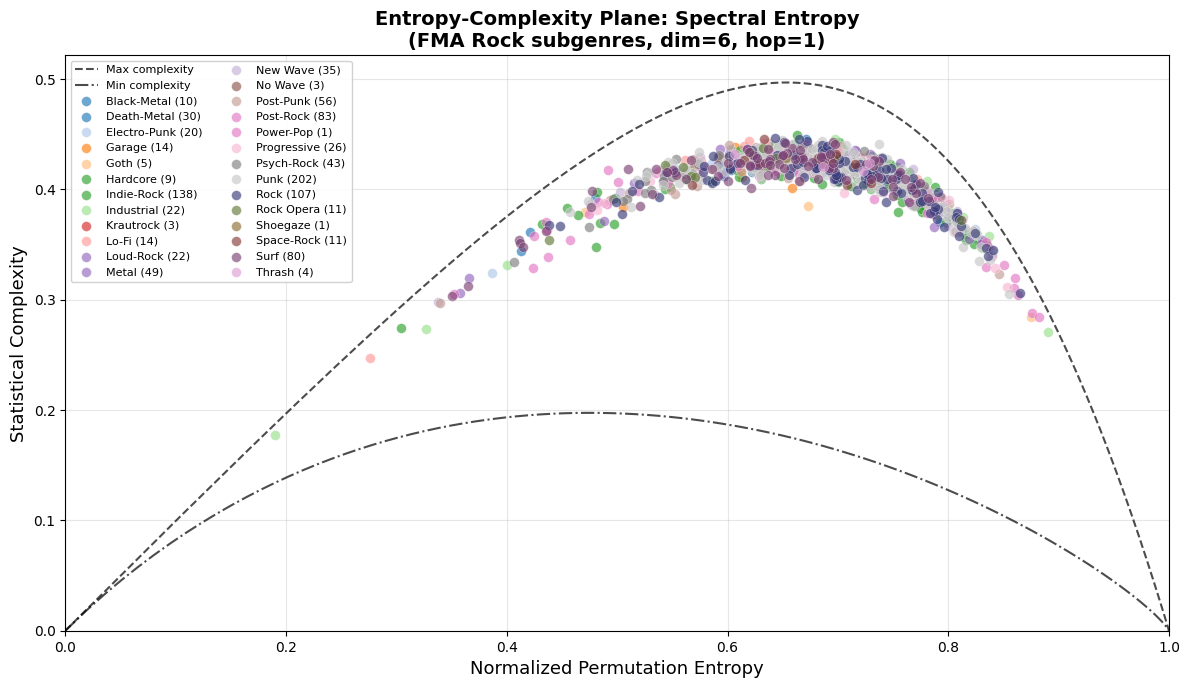

In [18]:
for method_name in METHODS.keys():
    df = results[method_name]
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Boundary curves
    ax.plot(max_HC[:, 0], max_HC[:, 1], 'k--', linewidth=1.5, alpha=0.7, label='Max complexity')
    ax.plot(min_HC[:, 0], min_HC[:, 1], 'k-.', linewidth=1.5, alpha=0.7, label='Min complexity')
    
    # Scatter by subgenre
    for sg in all_subgenres:
        mask = df['subgenre'] == sg
        if mask.sum() == 0:
            continue
        ax.scatter(
            df.loc[mask, 'H'], df.loc[mask, 'C'],
            c=[subgenre_colors[sg]],
            label=f'{sg} ({mask.sum()})',
            s=50, alpha=0.65, edgecolors='white', linewidths=0.3
        )
    
    title = method_titles.get(method_name, method_name)
    ax.set_xlabel('Normalized Permutation Entropy', fontsize=13)
    ax.set_ylabel('Statistical Complexity', fontsize=13)
    ax.set_title(f'Entropy-Complexity Plane: {title}\n(FMA Rock subgenres, dim={DIM}, hop={HOP})',
                 fontsize=14, fontweight='bold')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, None)
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', 'box')
    ax.legend(loc='upper left', fontsize=8, ncol=2, framealpha=0.9)
    
    plt.tight_layout()
    
    out_path = os.path.join(out_dir, f'EC_{method_name}_rock_d{DIM}_h{HOP}.png')
    plt.savefig(out_path, dpi=150, bbox_inches='tight')
    print(f'Saved → {out_path}')
    plt.show()

## 6. Summary Statistics

In [19]:
for method_name, df in results.items():
    print(f'\n{"="*50}')
    print(f'Method: {method_name}')
    print(f'{"="*50}')
    
    stats = df.groupby('subgenre').agg(
        n_tracks=('H', 'count'),
        H_mean=('H', 'mean'),
        H_std=('H', 'std'),
        C_mean=('C', 'mean'),
        C_std=('C', 'std')
    ).sort_values('n_tracks', ascending=False)
    
    print(stats.to_string(float_format='%.4f'))


Method: amplitude
              n_tracks  H_mean  H_std  C_mean  C_std
subgenre                                            
Punk               202  0.7744 0.0438  0.3768 0.0276
Indie-Rock         138  0.7610 0.0554  0.3775 0.0264
Rock               107  0.7578 0.0497  0.3821 0.0248
Post-Rock           83  0.7831 0.0457  0.3650 0.0329
Surf                80  0.7683 0.0524  0.3777 0.0281
Post-Punk           56  0.7738 0.0398  0.3751 0.0259
Metal               49  0.7881 0.0385  0.3715 0.0280
Psych-Rock          43  0.7919 0.0395  0.3635 0.0286
New Wave            35  0.7732 0.0439  0.3756 0.0261
Death-Metal         30  0.7979 0.0363  0.3618 0.0266
Progressive         26  0.7646 0.0558  0.3734 0.0278
Loud-Rock           22  0.8126 0.0345  0.3500 0.0314
Industrial          22  0.7805 0.0502  0.3702 0.0379
Electro-Punk        20  0.7501 0.0557  0.3857 0.0362
Lo-Fi               14  0.8010 0.0471  0.3537 0.0330
Garage              14  0.7802 0.0505  0.3717 0.0385
Rock Opera          11  0.7